In [ ]:
import os
import glob
import sys
import tempfile
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import convolve2d

import rasterio.features
import rasterio
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, Resampling

sys.path.append("../utils")

import config
import data_utils
import planet_api
import planet_utils

# geodetic = "EPSG:4326"
# mercator = "EPSG:3857"
# mollweide = "ESRI:54009"

In [66]:
PLANET_API_KEY = planet_api.key
planet = planet_utils.PlanetAPI(PLANET_API_KEY, planet_utils.basemap_url)
mosaic_names = planet.get_mosaics()

mosaic_names = [name for name in mosaic_names if "monthly" in name]
mosaic_names

['global_monthly_2016_01_mosaic',
 'global_monthly_2016_02_mosaic',
 'global_monthly_2016_03_mosaic',
 'global_monthly_2016_04_mosaic',
 'global_monthly_2016_05_mosaic',
 'global_monthly_2016_06_mosaic',
 'global_monthly_2016_07_mosaic',
 'global_monthly_2016_08_mosaic',
 'global_monthly_2016_09_mosaic',
 'global_monthly_2016_10_mosaic',
 'global_monthly_2016_11_mosaic',
 'global_monthly_2016_12_mosaic',
 'global_monthly_2017_01_mutate_mosaic',
 'global_monthly_2017_02_mosaic',
 'global_monthly_2017_03_mosaic',
 'global_monthly_2017_04_mosaic',
 'global_monthly_2017_05_mosaic',
 'global_monthly_2017_06_mosaic',
 'global_monthly_2017_07_mosaic',
 'global_monthly_2017_08_mosaic',
 'global_monthly_2017_09_mosaic',
 'global_monthly_2017_10_mosaic',
 'global_monthly_2017_11_mosaic',
 'global_monthly_2017_12_mosaic',
 'global_monthly_2018_01_mosaic',
 'global_monthly_2018_02_mosaic',
 'global_monthly_2018_03_mosaic',
 'global_monthly_2018_04_mosaic',
 'global_monthly_2018_05_mosaic',
 'globa

In [67]:
# mosaic = "global_monthly_2022_12_mosaic"
mosaic_names = ["global_monthly_2022_12_mosaic"]

<Axes: >

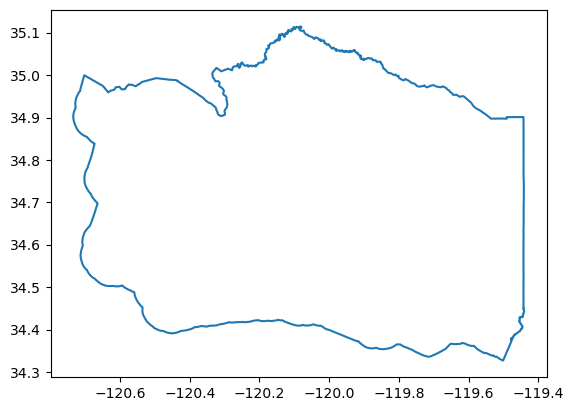

In [68]:
counties = gpd.read_file("../../data/ca_counties/CA_Counties.shp")
counties = counties.to_crs(geodetic)
sb_county = counties.loc[counties["NAME"] == "Santa Barbara"]
bbox = [-125, 34.25, -119.0, 38.0]
sb_county = sb_county.clip(bbox)
sb_county.boundary.plot()

In [69]:
sb_grid = data_utils.create_grid(
    sb_county,
    resolution=0.01,
    geometry_col="geometry",
    id_col="NAME",
    return_ids=True,
)
sb_grid_gdf = gpd.GeoDataFrame(
    sb_grid,
    geometry=gpd.points_from_xy(sb_grid.lon, sb_grid.lat),
    crs="EPSG:4326",
)
sb_grid_gdf.geometry = sb_grid_gdf.geometry.buffer(0.005, cap_style=3)

print(f"Shape (row, col): {sb_grid_gdf.shape}")

sb_grid_gdf.head()

Shape (row, col): (7507, 5)


/tmp/ipykernel_5314/2638617555.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sb_grid_gdf.geometry = sb_grid_gdf.geometry.buffer(0.005, cap_style=3)


lat      lon           NAME                 unique_id  \
0  35.115 -120.085  Santa Barbara  lon_-120.085__lat_35.115   
1  35.105 -120.115  Santa Barbara  lon_-120.115__lat_35.105   
2  35.105 -120.105  Santa Barbara  lon_-120.105__lat_35.105   
3  35.105 -120.095  Santa Barbara  lon_-120.095__lat_35.105   
4  35.105 -120.085  Santa Barbara  lon_-120.085__lat_35.105   

                                            geometry  
0  POLYGON ((-120.08 35.12, -120.08 35.11, -120.0...  
1  POLYGON ((-120.11 35.11, -120.11 35.1, -120.12...  
2  POLYGON ((-120.1 35.11, -120.1 35.1, -120.11 3...  
3  POLYGON ((-120.09 35.11, -120.09 35.1, -120.1 ...  
4  POLYGON ((-120.08 35.11, -120.08 35.1, -120.09...

In [70]:
basemap_dir = "../../data/basemaps"

planet.set_mosaic(mosaic_names[0])
bbox_aoi = sb_county.geometry.total_bounds
all_items = planet.get_items(bbox_aoi)
quad_df = planet.convert_items_to_geodataframe(all_items)
quad_df = quad_df.drop_duplicates(subset="id")

quad_df = quad_df.sjoin(sb_county, predicate="intersects")
quad_df.drop(columns=["index_right"], inplace=True)
quad_df.head()

id                                           geometry STATEFP  \
0  341-1233  POLYGON ((-120.05859 34.45222, -119.88281 34.4...      06   
1  339-1233  POLYGON ((-120.41016 34.45222, -120.23438 34.4...      06   
2  344-1232  POLYGON ((-119.53125 34.30714, -119.35547 34.3...      06   
3  340-1235  POLYGON ((-120.23438 34.74161, -120.05859 34.7...      06   
4  339-1232  POLYGON ((-120.41016 34.30714, -120.23438 34.3...      06   

  COUNTYFP  COUNTYNS  GEOID           NAME              NAMELSAD LSAD CLASSFP  \
0      083  00277306  06083  Santa Barbara  Santa Barbara County   06      H1   
1      083  00277306  06083  Santa Barbara  Santa Barbara County   06      H1   
2      083  00277306  06083  Santa Barbara  Santa Barbara County   06      H1   
3      083  00277306  06083  Santa Barbara  Santa Barbara County   06      H1   
4      083  00277306  06083  Santa Barbara  Santa Barbara County   06      H1   

   MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT         ALAND        AWATER  \
0  G4020  None  42200     None        A  7.084063e+09  2.729752e+09   
1  G4020  None  42200     None        A  7.084063e+09  2.729752e+09   
2  G4020  None  42200     None        A  7.084063e+09  2.729752e+09   
3  G4020  None  42200     None        A  7.084063e+09  2.729752e+09   
4  G4020  None  42200     None        A  7.084063e+09  2.729752e+09   

      INTPTLAT      INTPTLON     Shape_Leng    Shape_Area  
0  +34.5370572  -120.0399729  891686.747247  1.449841e+10  
1  +34.5370572  -120.0399729  891686.747247  1.449841e+10  
2  +34.5370572  -120.0399729  891686.747247  1.449841e+10  
3  +34.5370572  -120.0399729  891686.747247  1.449841e+10  
4  +34.5370572  -120.0399729  891686.747247  1.449841e+10

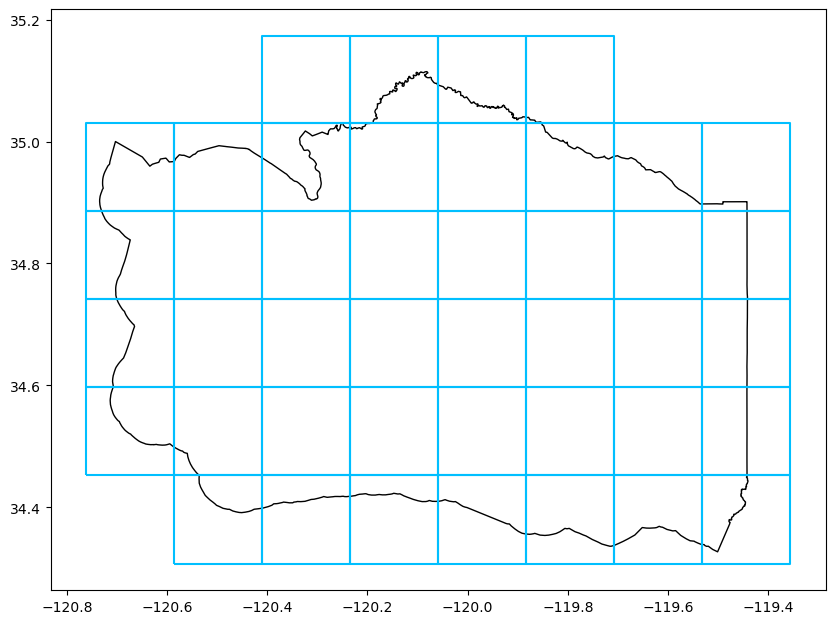

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))

quad_df.boundary.plot(ax=ax, edgecolor="grey", color="deepskyblue")
sb_county.plot(ax=ax, color="None", edgecolor="black")

plt.show()

In [72]:
intersecting = gpd.sjoin(
    sb_grid_gdf.reset_index(),
    quad_df,
    how="left",
    predicate="intersects",
)

sb_grid_gdf["id"] = intersecting.groupby("index")["id"].apply(list).values

sb_grid_gdf = sb_grid_gdf[
    ~sb_grid_gdf["id"].apply(data_utils.contains_nan)
]

sb_grid_gdf = sb_grid_gdf.to_crs(mercator)

file_dir = os.path.join(basemap_dir, mosaic_names[0], "quad_ids")
os.makedirs(file_dir, exist_ok=True)

quad_fn = os.path.join(file_dir, "quad_ids.geojson")
quad_df.to_file(quad_fn, driver="GeoJSON")

grid_fn = os.path.join(file_dir, "sb_grid_gdf.parquet")
sb_grid_gdf.to_parquet(grid_fn)

In [73]:
for mosaic in sorted(mosaic_names, reverse=True):
    print(f"Processing {mosaic}...", end="\n")
    mosaic_dir = basemap_dir + "/" + mosaic
    quad_dir = mosaic_dir + "/basemap_quads"
    quad_id_fp = mosaic_dir + "/quad_ids/quad_ids.geojson"

    quad_df = gpd.read_file(quad_id_fp, driver="GeoJSON")

    quad_ids_list = quad_df.id.tolist()

    os.makedirs(quad_dir, exist_ok=True)
    existing_files = os.listdir(quad_dir)

    filtered_quad_ids_list = planet_utils.filter_existing_quad_ids(
        quad_ids_list, existing_files
    )
    chunked_quad_id_list = planet_utils.chunk_list(filtered_quad_ids_list, 100)

    print(f"N Quads: {len(quad_ids_list)}")
    print(f"N Quads Remaining: {len(filtered_quad_ids_list)}")
    print(f"N Chunks: {len(chunked_quad_id_list)}")

    for i in range(len(chunked_quad_id_list)):
        print(f"Chunk: {i + 1}/{len(chunked_quad_id_list)}", end="\n")

        order_params = {
            "name": "Basemap order with geometry",
            "source_type": "basemaps",
            "order_type": "partial",
            "products": [
                {
                    "mosaic_name": mosaic,
                    "quad_ids": chunked_quad_id_list[i],
                }
            ],
        }

        order = planet.place_order(order_params)

        print("Polling for order success...", end="\n")

        planet.poll_for_success(order, loop_time=10, num_loops=240)

        results = planet.get_results(order)

        planet.download_results(
            results,
            directory=basemap_dir,
            overwrite=False,
            show_progress=True,
            max_retries=5,
        )

        # print("Organizing files...", end="\n")

        # planet.organize_files(
        #     base_dir=basemap_dir,
        #     mosaic_name=mosaic,
        #     overwrite=False,
        #     verbose=False,
        # )

        print("Done!", end="\n\n")

Processing global_monthly_2022_12_mosaic...
N Quads: 43
N Quads Remaining: 0
N Chunks: 0


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


In [74]:
image_dir = os.path.join(basemap_dir, mosaic_names[0], "basemap_quads")

image = os.listdir(image_dir)[0]

image_path = os.path.join(image_dir, image)

image_path

'../../data/basemaps/global_monthly_2022_12_mosaic/basemap_quads/344-1232_quad.tif'

In [75]:


with rasterio.open(image_path) as src:
    rast = src.read([1, 2, 3])

print(f"""
Shape: {rast.shape}
CRS: {src.crs}
Driver: {src.driver}
Data type: {src.dtypes[0]}
Dataset name: {src.name}
Bounds: {src.bounds}
Data sample: 
{rast[:1]}
""")


Shape: (3, 4096, 4096)
CRS: EPSG:3857
Driver: GTiff
Data type: uint8
Dataset name: ../../data/basemaps/global_monthly_2022_12_mosaic/basemap_quads/344-1232_quad.tif
Bounds: BoundingBox(left=-13306157.882029148, bottom=4070118.8815700314, right=-13286590.00279086, top=4089686.760808319)
Data sample: 
[[[ 75 132 144 ... 174 165 143]
  [131 136 109 ... 182 199 202]
  [191 132  89 ... 174 191 217]
  ...
  [ 12  17  19 ...  14  25  22]
  [ 26  19  19 ...  21  28  26]
  [ 29  22  20 ...  33  30  30]]]



In [76]:

def read_and_downscale(image_path, downscale_factor=10):
    with rasterio.open(image_path) as src:
        # Initialize an empty array to hold the downscaled data
        downscaled_data = np.zeros(
            (3, int(src.height / downscale_factor), int(src.width / downscale_factor)),
            dtype=src.meta["dtype"],
        )

        # Iterate over the first three bands and downscale each
        for band in range(1, 4):  # Bands 1, 2, 3 (Blue, Green, Red)
            data = src.read(
                band,
                out_shape=(
                    1,
                    int(src.height / downscale_factor),
                    int(src.width / downscale_factor),
                ),
                resampling=Resampling.bilinear,
            )
            downscaled_data[band - 1, :, :] = data

    return downscaled_data

In [77]:
# List to keep track of paths to the downscaled images
downscaled_image_paths = []
for idx, row in tqdm(
    quad_df.iterrows(), total=quad_df.shape[0], desc="Processing Images"
):
    image_path = os.path.join(quad_dir, f"{row['id']}_quad.tif")
    downscaled_image = read_and_downscale(image_path)

    # Open the original image to get its metadata
    with rasterio.open(image_path) as src:
        meta = src.meta.copy()
        # Update metadata for the downscaled image
        meta.update(
            {
                "driver": "GTiff",
                "height": downscaled_image.shape[1],
                "width": downscaled_image.shape[2],
                "count": 3,  # Number of bands
                "dtype": downscaled_image.dtype,
                "transform": src.transform
                * src.transform.scale(
                    (src.width / downscaled_image.shape[2]),
                    (src.height / downscaled_image.shape[1]),
                ),
            }
        )

    # Save the downscaled image as a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".tif") as temp_file:
        temp_file_path = temp_file.name

        # Save using rasterio
        with rasterio.open(temp_file_path, "w", **meta) as dst:
            dst.write(downscaled_image)

        downscaled_image_paths.append(temp_file_path)
        


Processing Images: 100%|██████████| 43/43 [00:00<00:00, 75.41it/s]


In [78]:
# Use rasterio to merge the temporary files
with rasterio.open(downscaled_image_paths[0]) as src0:
    meta = src0.meta.copy()

# Create a mosaic
mosaic, out_trans = merge(downscaled_image_paths, method="first")


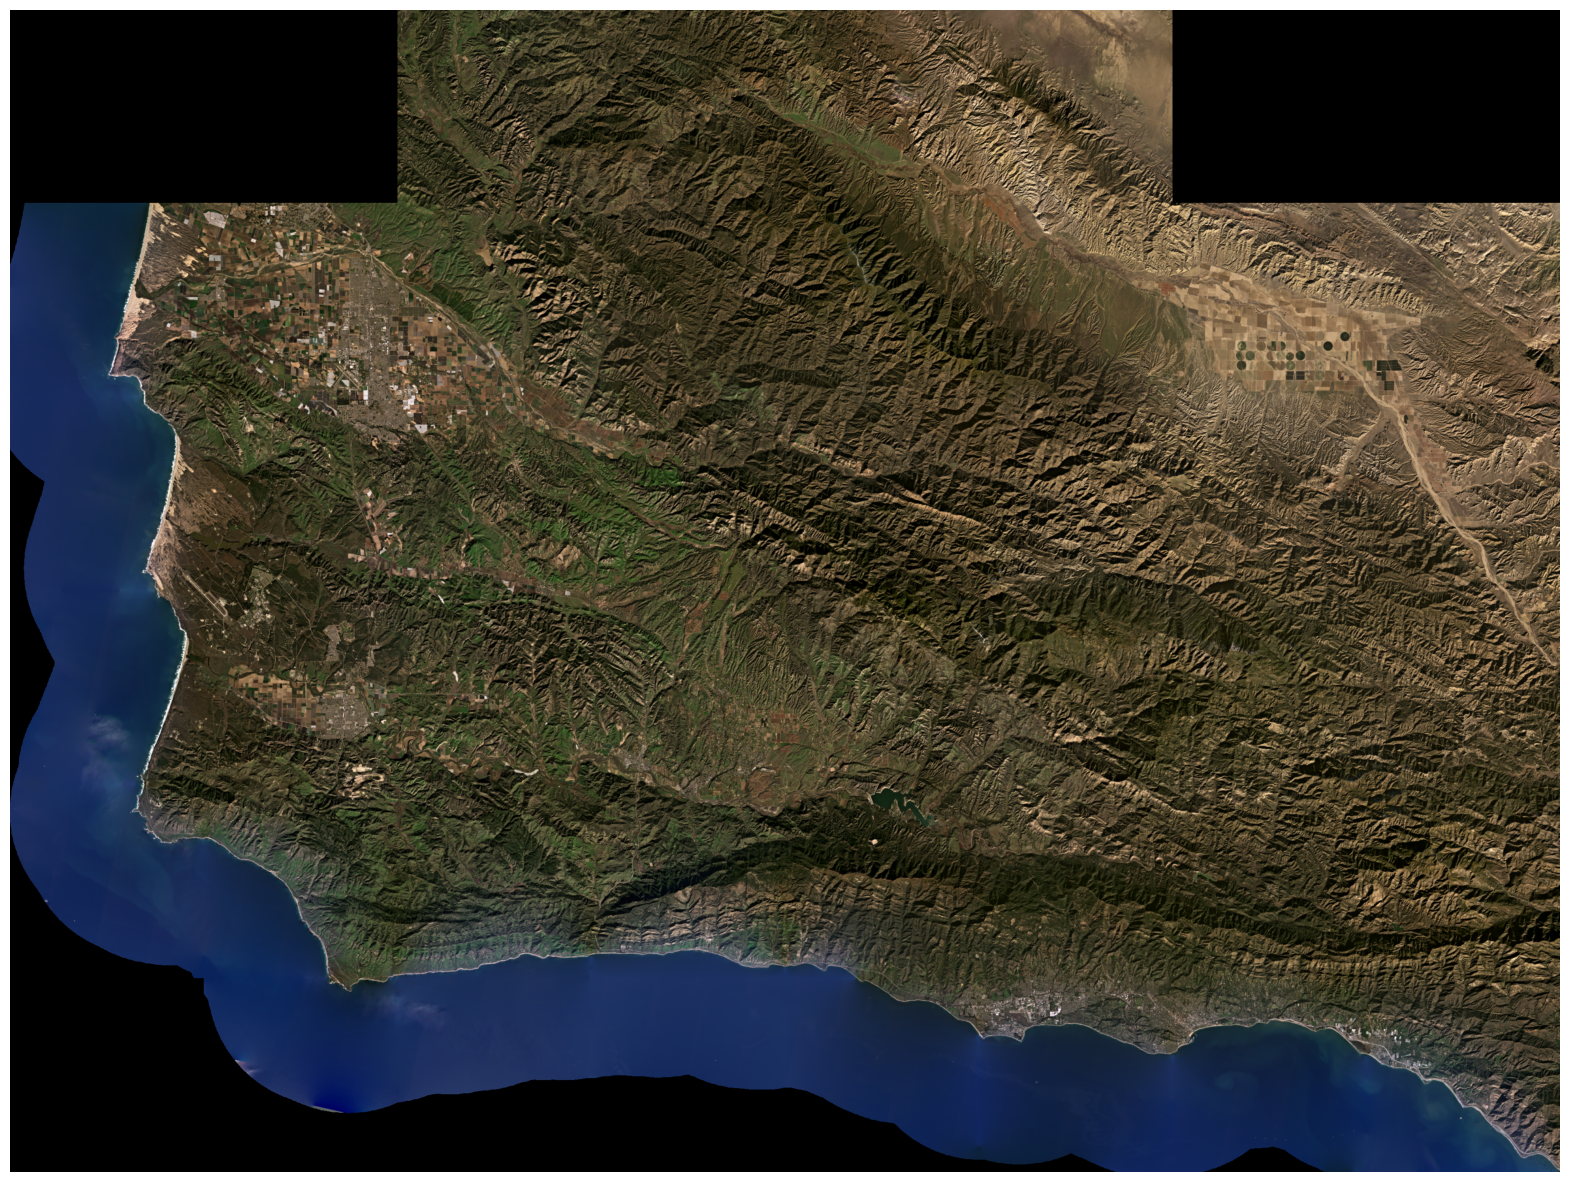

In [79]:
# Clean up temporary files
for temp_file_path in downscaled_image_paths:
    os.remove(temp_file_path)
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(mosaic.transpose((1, 2, 0)))
ax.axis("off")
plt.show()

In [80]:
data_dir = os.path.join("/capstone", "wildfire_prep", "data-preparation", "planet_download", "data")

parcel_fp = os.path.join(
    data_dir, "parcel_data", "Defensible_Space_2024_address_points.gdb"
)

parcel_data = gpd.read_file(parcel_fp)

parcel_data.geometry = gpd.points_from_xy(parcel_data._longitude, parcel_data._latitude)

parcel_data


/Users/ryangreen/.conda/envs/prg/lib/python3.12/site-packages/pyogrio/geopandas.py:265: UserWarning: More than one layer found in 'Defensible_Space_2024_address_points.gdb': 'T2024_Defensible_Space_LatLong_Addr' (default), 'T2024_Defensible_Space_LatLong_Addr_Points', 'c2024_Defensible_Space_LatLong_Addr_XYTableToPoint'. Specify layer parameter to avoid this warning.
  result = read_func(
/tmp/ipykernel_5314/1291756682.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  parcel_data.geometry = gpd.points_from_xy(parcel_data._longitude, parcel_data._latitude)


_latitude  _longitude                                           address
0      34.713144 -120.111912  4551 Figueroa Mountain Rd Santa Ynez CA 93441 US
1      34.711830 -120.111129  4551 Figueroa Mountain Rd Santa Ynez CA 93441 US
2      34.747729 -120.028376  7445 Figueroa Mountain Rd Santa Ynez CA 93460 US
3      34.747324 -120.027858  7445 Figueroa Mountain Rd Santa Ynez CA 93460 US
4      34.746687 -120.028255  7445 Figueroa Mountain Rd Santa Ynez CA 93460 US
...          ...         ...                                               ...
14879  34.686215 -119.902500       9500 Happy Canyon Rd Santa Ynez CA 93460 US
14880  34.686091 -119.903605       9500 Happy Canyon Rd Santa Ynez CA 93460 US
14881  34.687801 -119.902894       9500 Happy Canyon Rd Santa Ynez CA 93460 US
14882  34.728377 -119.991868  9000 Figueroa Mountain Rd Santa Ynez CA 93460 US
14883  34.728571 -119.987437  9000 Figueroa Mountain Rd Santa Ynez CA 93460 US

[14884 rows x 3 columns]

In [81]:
inspection_fp = os.path.join(
    data_dir,
    "inspections_data",
    "2022_defensible_space_inspections_SBC",
    "2022_defensible_space_inspections_SBC.shp",
)

pd.set_option('display.max_columns', None)

inspection_2022 = gpd.read_file(inspection_fp)
inspection_2022.head()

fulcrum_id               created_at  \
0  48c58877-f0ce-438d-ac87-6434a2c15fe8  2022-02-14 10:44:17 PST   
1  2f9d4c7c-54cb-415d-aae4-57f9b6c18994  2022-02-28 16:11:51 PST   
2  f351800c-fc5c-4b79-bf24-a41775b74d7c  2022-04-05 13:47:06 PDT   
3  b97b5b98-bda4-4b41-b850-3fdb36c9f689  2022-04-05 13:47:07 PDT   
4  03dfcea7-bf0a-461f-92a0-42ac0d84d6ed  2022-04-05 13:47:07 PDT   

                updated_at               system_cre               system_upd  \
0  2022-05-24 12:22:14 PDT  2022-02-14 10:44:17 PST  2022-05-24 12:22:23 PDT   
1  2022-10-25 11:33:18 PDT  2022-02-28 16:11:51 PST  2022-10-25 11:34:34 PDT   
2  2022-09-05 13:47:11 PDT  2022-04-05 13:47:06 PDT  2022-09-05 13:55:48 PDT   
3  2022-09-05 13:35:19 PDT  2022-04-05 13:47:07 PDT  2022-09-05 13:55:36 PDT   
4  2022-09-05 13:35:51 PDT  2022-04-05 13:47:07 PDT  2022-09-05 13:55:37 PDT   

   version     status project assigned_t   latitude   longitude  \
0      8.0  Compliant    None       None  34.461625 -119.772555   
1      6.0  Compliant    None       None  34.446105 -119.720859   
2      4.0  Compliant    None       None  34.672591 -120.108711   
3      4.0  Compliant    None       None  34.668610 -120.115221   
4      4.0  Compliant    None       None  34.669655 -120.115747   

                           report_tit globalid  keyid propertyst inspection  \
0  Defensible Space Inspection Report     None    NaN       None       None   
1  Defensible Space Inspection Report     None    NaN       None       None   
2  Defensible Space Inspection Report     None    0.0       None       None   
3  Defensible Space Inspection Report     None    0.0       None       None   
4  Defensible Space Inspection Report     None    0.0       None       None   

  inspectorp  inspecti_1                addressvis address_su  \
0     Engine  2022-05-24  Yes - Without Reflective       4440   
1        DSI  2022-10-25  Yes - Without Reflective       2928   
2        DSI  2022-08-31  Yes - Without Reflective     3110 A   
3        DSI  2022-08-31  Yes - Without Reflective       3035   
4        DSI  2022-08-31  Yes - Without Reflective       3055   

             address_th address__1     address_lo     address__2 address_ad  \
0      Shadow Hills Cir       None  Santa Barbara  Santa Barbara         CA   
1       La Combadura Rd       None  Santa Barbara  Santa Barbara         CA   
2             Acampo Rd       None     Santa Ynez  Santa Barbara         CA   
3  Figueroa Mountain Rd       None     Santa Ynez  Santa Barbara         CA   
4  Figueroa Mountain Rd       None     Los Olivos  Santa Barbara         CA   

  address_po address_co                                         address_fu  \
0      93105         US  4440 Shadow Hills Cir Santa Barbara Santa Barb...   
1      93105         US  2928 La Combadura Rd Santa Barbara Santa Barba...   
2      93441         US  3110 A Acampo Rd Santa Ynez Santa Barbara CA 9...   
3      93441         US  3035 Figueroa Mountain Rd Santa Ynez Santa Bar...   
4      93441         US  3055 Figueroa Mountain Rd Los Olivos Santa Bar...   

  calfireuni county             community community_ battalion  enginenumb  \
0        SBC    SBA  San Marcos Foothills       None         1         NaN   
1        SBC    SBA        Mission Canyon       None         1         NaN   
2        SBC    SBA            Los Olivos       None         3        32.0   
3        SBC    SBA            Los Olivos       None         3        32.0   
4        SBC    SBA            Los Olivos       None         3        32.0   

                                    stationnam shift shift_juli accessegre  \
0                                           13     A        144        Yes   
1                                           15     C        298        Yes   
2  Santa Ynez Valley (Outside Engine Co. Area)     C        248        Yes   
3  Santa Ynez Valley (Outside Engine Co. Area)     C        248        Yes   
4  Santa Ynez Valley (Outside Engine Co. Area)     C        248    

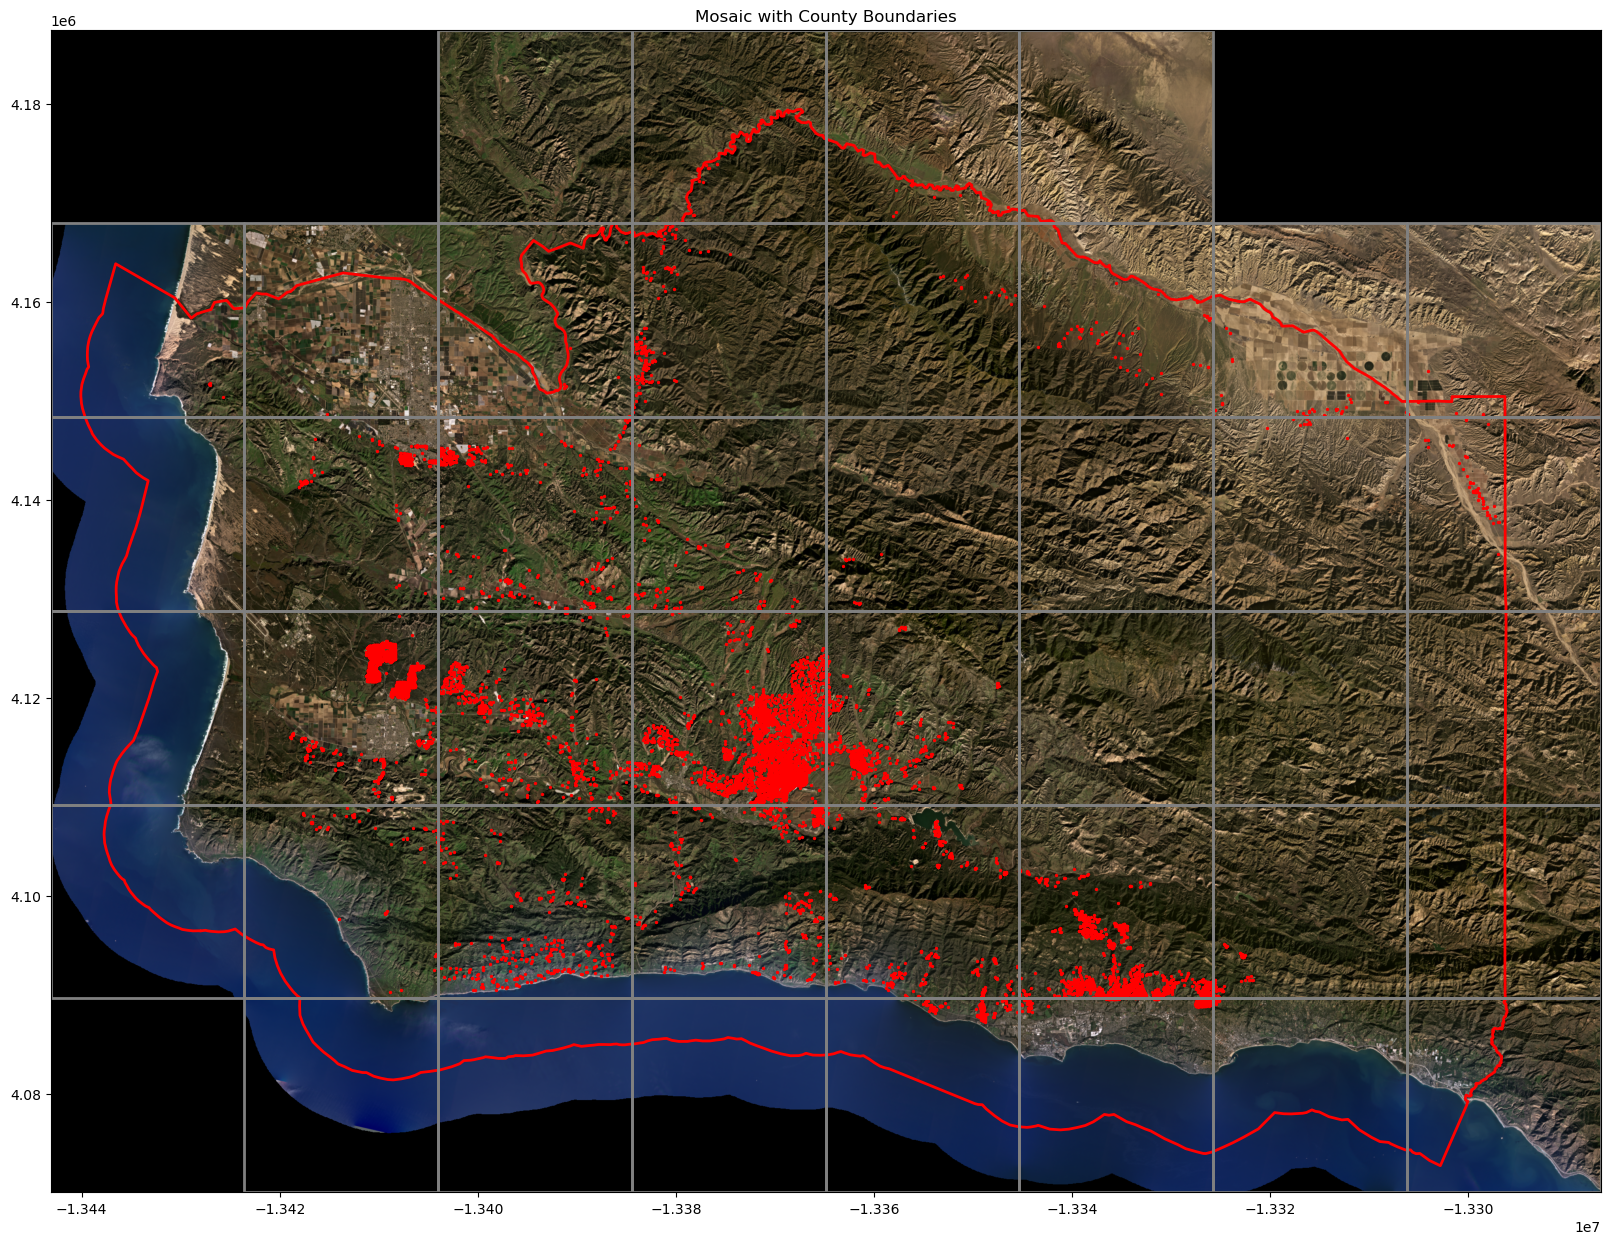

In [82]:

# After creating the mosaic, update the metadata with the output transform and save it
meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans,  # Use the transform from merge
})

# Save the final mosaic with spatial information
output_mosaic_path = "mosaic.tif"
with rasterio.open(output_mosaic_path, "w", **meta) as dst:
    dst.write(mosaic)

# Now you can plot everything together
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the mosaic with proper spatial reference
with rasterio.open(output_mosaic_path) as src:
    show(src, ax=ax)

# Plot the county boundaries and quad boundaries
quad_df.to_crs(mercator).boundary.plot(ax=ax, edgecolor="grey", linewidth=2)
sb_county.to_crs(mercator).plot(ax=ax, color="none", edgecolor="red", linewidth=2)

# Plot the parcels inspection points
inspection_2022.to_crs(mercator).plot(ax=ax, markersize=2, color="red", label="2022 Inspections")

ax.set_title("Mosaic with County Boundaries")
plt.show()

In [83]:
gbd_path = "/capstone/wildfire_prep/data-preparation/planet_download/data/parcel_boundaries/cbiinputs.gdb"
geodetic = "EPSG:4326"

parcels = gpd.read_file(gbd_path)
parcels = parcels.to_crs("EPSG:4326")
print("Parcels CRS:", parcels.crs)

Parcels CRS: EPSG:4326


<Axes: >

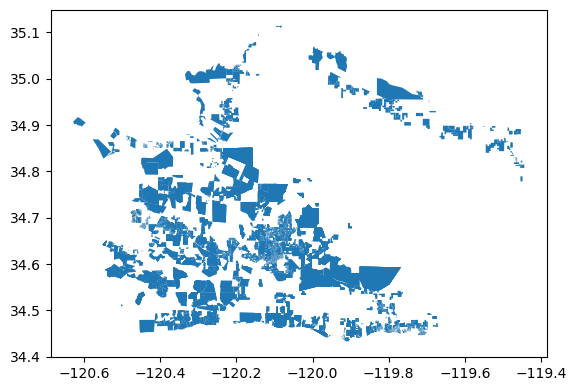

In [84]:
parcels = parcels.to_crs(inspection_2022.crs)
inspected_parcels = gpd.sjoin(parcels, inspection_2022, how="inner", predicate="contains")
inspected_parcels.plot()

In [88]:
# Open the raster file
with rasterio.open("mosaic.tif") as src:
    # Check if CRS matches
    if inspected_parcels.crs != src.crs:
        inspected_parcels = inspected_parcels.to_crs(src.crs)
    
    # Extract geometries in a format compatible with rasterio.mask.mask
    geoms = [feature for feature in inspected_parcels.geometry]

    # Clip the raster using the geometry from the shapefile
    out_image, out_transform = mask(src, geoms, crop=True)
    
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

# Save the clipped raster to a new file
with rasterio.open("mosaic_clipped_2022.tif", "w", **out_meta) as dest:
    dest.write(out_image)

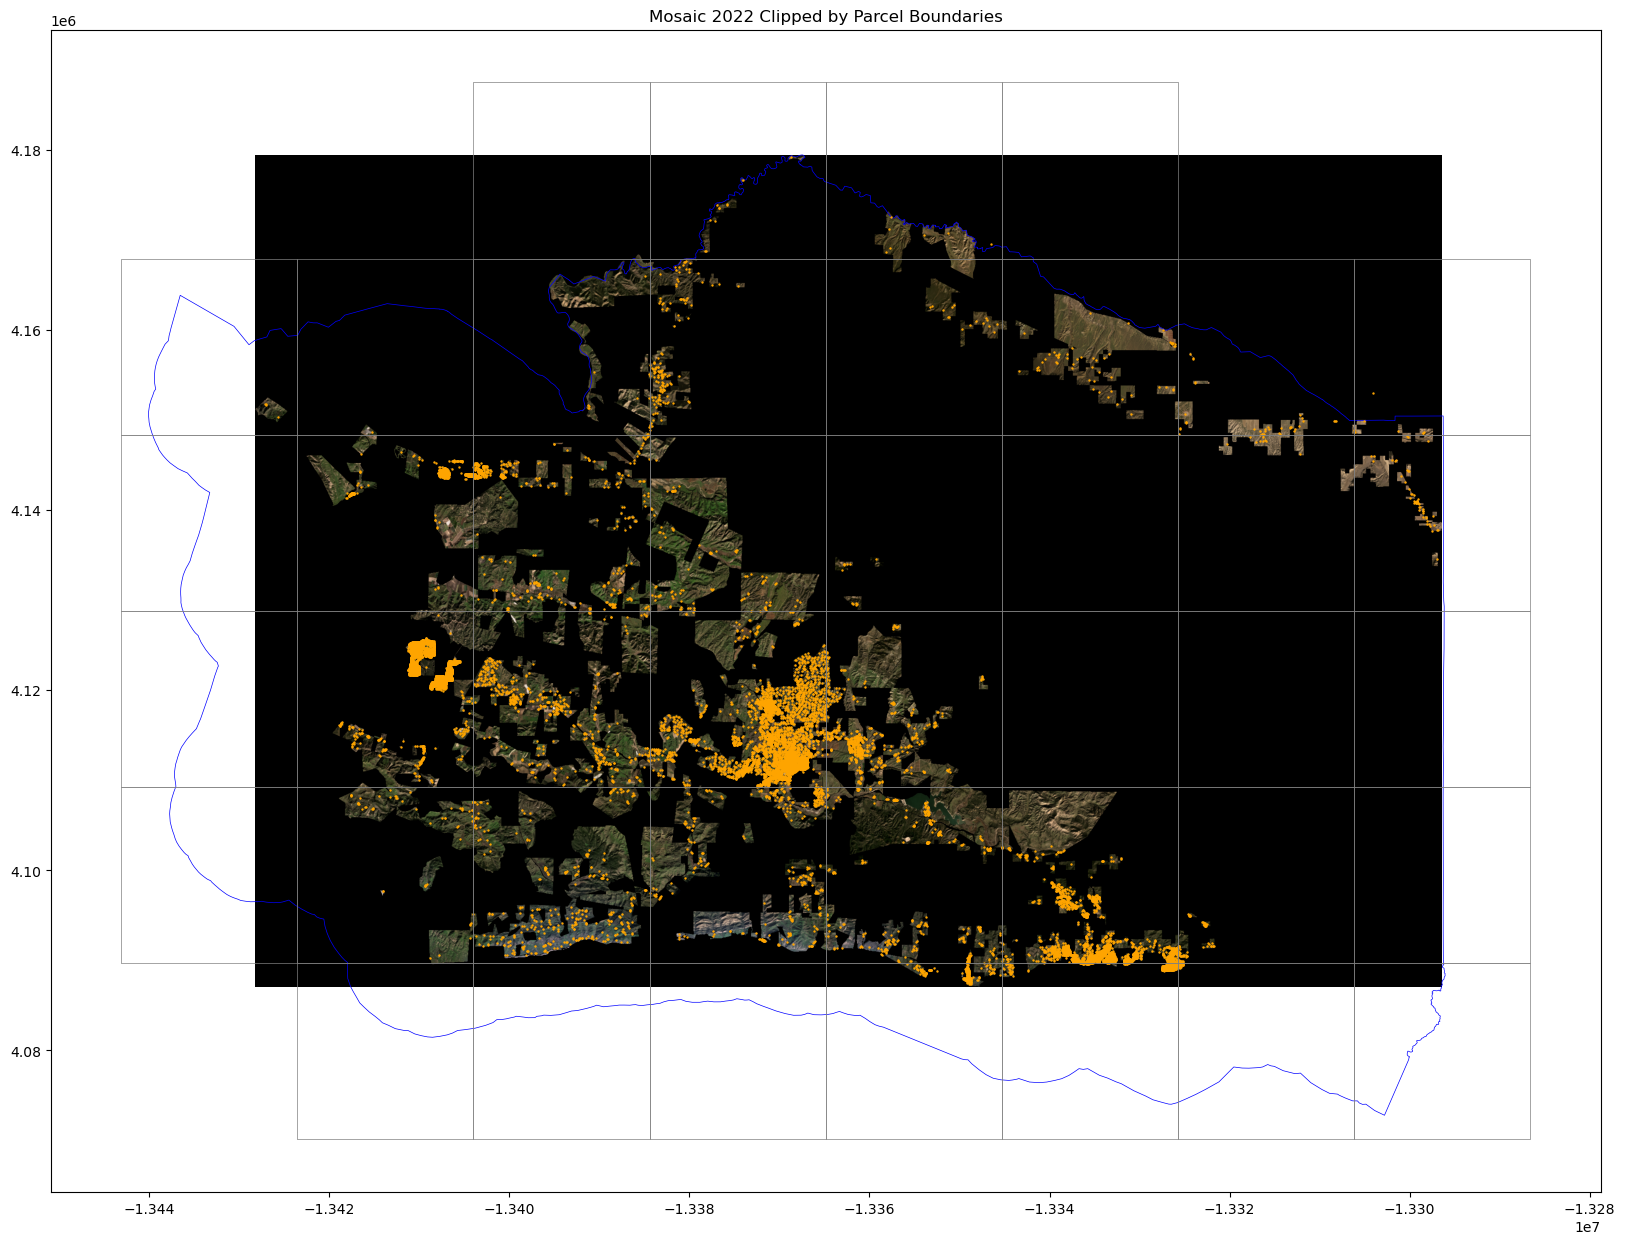

In [89]:
# Now you can plot everything together
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the mosaic with proper spatial reference
with rasterio.open("mosaic_clipped_2022.tif") as src:
    show(src, ax=ax)

# Plot the county boundaries and quad boundaries
quad_df.to_crs(mercator).boundary.plot(ax=ax, edgecolor="grey", linewidth=0.5)
sb_county.to_crs(mercator).plot(ax=ax, color="none", edgecolor="blue", linewidth=0.5)

# Plot the parcels inspection points
inspection_2022.to_crs(mercator).plot(ax=ax, markersize=.5, color="orange", label="2022 Inspections")

ax.set_title("Mosaic 2022 Clipped by Parcel Boundaries")
plt.show()